In [ ]:
%pip install -r seggpt/requirements.txt
%pip install -q autodistill roboflow supervision pycocotools

In [1]:
from roboflow import login,Roboflow

login()
rf = Roboflow()

project = rf.workspace("roboflow-4rfmv").project("climbing-y56wy")
dataset = project.version(5).download("coco-segmentation")

You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-5 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 2863.54it/s]


In [2]:
import supervision as sv

climbing_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=True
)

In [3]:
from autodistill_seggpt.find_best_ontology import find_best_examples
from autodistill_seggpt.seggpt import SegGPT

best_examples = find_best_examples(climbing_dataset,SegGPT,num_examples=2,num_trials=10)
best_examples

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Finding best examples for class 1-climbing-holds.


Curr IoU: 0.2: 100%|██████████| 10/10 [10:06<00:00, 60.66s/it]


Finding best examples for class 2-floor.


Curr IoU: 0.82: 100%|██████████| 10/10 [08:48<00:00, 52.84s/it]


Finding best examples for class 3-person.


Curr IoU: 0.67: 100%|██████████| 10/10 [08:49<00:00, 52.92s/it]


In [4]:
from autodistill_seggpt.seggpt import FewShotOntology,SegGPT
from autodistill import CaptionOntology

climbing_ontology = CaptionOntology({
    "2-floor":"floor",
    "1-climbing-holds":"hold",
    "3-person":"climber",
})

few_shot_ontology = FewShotOntology.from_examples(
    ref_dataset=climbing_dataset,
    ontology=climbing_ontology,
    examples=best_examples
)

model = SegGPT(
    ontology=few_shot_ontology,
)

In [5]:
demo_img = f"{dataset.location}/valid/AF1QipPELU8SBYp46tI_MeyEaIEWqYYQokSmJHBLgUuy-s1024_jpeg.rf.deb882dc76686fa35048f0724332e0a9.jpg"
detections = model.predict(demo_img)


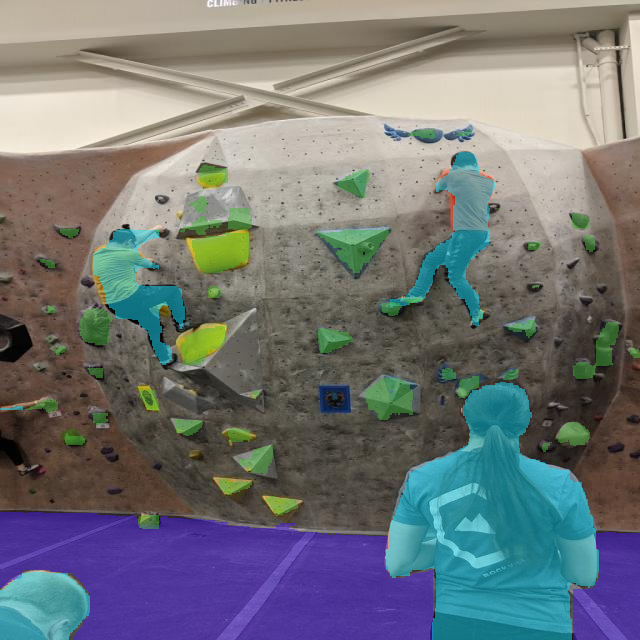

In [6]:
import cv2
from PIL import Image

annotator = sv.MaskAnnotator()
img = cv2.imread(demo_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

annotated_frame = annotator.annotate(
    scene=img.copy(),
    detections=detections
)
Image.fromarray(annotated_frame)